## Import libraries

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

import gc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_percentage_error

from lightgbm import LGBMRegressor

np.random.seed(42)

## Load source datasets

In [2]:
train = pd.read_csv("../input/renew-data-preprocess/train.csv")
print(f"train: {train.shape}")
train.head()

train: (909604, 31)


,active_power_calculated_by_converter,ambient_temperature,generator_speed,generator_winding_temp_max,grid_power10min_average,nc1_inside_temp,nacelle_temp,reactice_power_calculated_by_converter,wind_speed_raw,wind_speed_turbulence,...,power_ratio5,power_ratio6,power_ratio7,nacelle_temp_ratio,nacelle_temp_diff,nacelle_ambient_temp_diff,nacelle_ambient_temp_ratio,temp_avg,wind_direction_sin,wind_direction_cos
0,0.408318,0.613994,0.915144,0.386890,0.458951,0.497983,0.478286,0.545956,0.325693,0.057063,...,0.000003,0.002194,0.000009,0.259173,0.367857,0.180091,0.054556,0.595187,0.008963,0.594250
1,0.209554,0.171368,0.732948,0.325640,0.222778,0.510990,0.516904,0.483897,0.241944,0.049192,...,0.000003,0.002194,0.000009,0.283021,0.402985,0.834179,0.526251,0.430147,0.065048,0.746616
2,0.651765,0.259741,0.947977,0.341945,0.682361,0.007322,0.071699,0.651816,0.380506,0.065268,...,0.000004,0.002194,0.000009,0.921857,0.727568,0.241233,0.087251,0.218837,0.998067,0.543929
3,0.030747,0.536150,0.607514,0.144305,0.007162,0.554918,0.514037,0.456620,0.167626,0.079784,...,0.000015,0.002217,0.000026,0.221799,0.307781,0.325729,0.102320,0.418384,0.999429,0.523896
4,0.296757,0.609877,0.826204,0.371417,0.299511,0.510555,0.477103,0.540858,0.288687,0.036295,...,0.000004,0.002194,0.000009,0.240646,0.340027,0.184544,0.055867,0.586000,0.138666,0.845604


In [3]:
test = pd.read_csv("../input/renew-data-preprocess/test.csv")
print(f"test: {test.shape}")
test.head()

test: (303202, 30)


,active_power_calculated_by_converter,ambient_temperature,generator_speed,generator_winding_temp_max,grid_power10min_average,nc1_inside_temp,nacelle_temp,reactice_power_calculated_by_converter,wind_speed_raw,wind_speed_turbulence,...,power_ratio5,power_ratio6,power_ratio7,nacelle_temp_ratio,nacelle_temp_diff,nacelle_ambient_temp_diff,nacelle_ambient_temp_ratio,temp_avg,wind_direction_sin,wind_direction_cos
0,0.007754,0.815039,0.323988,0.304395,0.042004,0.904835,0.906080,0.380883,0.081212,0.082900,...,7.690738e-07,0.002193,0.000007,0.195332,0.215033,0.353636,0.095282,0.812131,0.700179,0.041821
1,0.236289,0.157517,0.761618,0.251035,0.246267,0.391749,0.248036,0.492167,0.264465,0.057075,...,3.517404e-06,0.002194,0.000009,0.137712,0.217567,0.569225,0.347376,0.274635,0.916672,0.776383
2,0.223915,0.553069,0.748169,0.334485,0.196577,0.678749,0.608271,0.485162,0.265764,0.053854,...,4.165736e-06,0.002195,0.000009,0.170673,0.203557,0.401875,0.125650,0.621230,0.149295,0.143622
3,0.127007,0.505230,0.635260,0.288893,0.089358,0.440234,0.467395,0.484001,0.185554,0.047078,...,5.132108e-06,0.002196,0.000010,0.333348,0.469495,0.319278,0.102320,0.471071,0.481230,0.000352
4,0.587465,0.624684,0.946821,0.399539,0.557928,0.498909,0.458517,0.603270,0.366207,0.058886,...,3.881753e-06,0.002194,0.000009,0.236208,0.334229,0.144386,0.044196,0.603445,0.005272,0.427585


In [4]:
features = test.columns.tolist()

In [5]:
cat_cols = ['turbine_id']
train[cat_cols] = train[cat_cols].astype(int)
test[cat_cols] = test[cat_cols].astype(int)
cat_cols_indices = [train.columns.get_loc(col) for col in cat_cols]
print(cat_cols_indices)

[10]


## LightGBM

In [6]:
splits = 10
skf = StratifiedKFold(n_splits=splits, shuffle=True, random_state=42)

lgb_oof_preds = np.zeros((train.shape[0],))
lgb_model_preds = 0
fet_imp = 0

for fold, (train_idx, valid_idx) in enumerate(skf.split(train, train['turbine_id'])):
    X_train, X_valid = train.loc[train_idx][features], train.loc[valid_idx][features]
    y_train, y_valid = train.loc[train_idx]['Target'], train.loc[valid_idx]['Target']
    
    model = LGBMRegressor(
        boosting_type='gbdt', 
        num_leaves=252, 
        max_depth=10, 
        learning_rate=0.25, 
        n_estimators=5000, 
        objective='regression',
        metric='mape',
        min_child_samples=1, 
        subsample=0.87, 
        subsample_freq=4, 
        colsample_bytree=0.85, 
        reg_alpha=1.0, 
        reg_lambda=0.005, 
        random_state=42
    )
    
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], 
              categorical_feature=cat_cols_indices, 
              early_stopping_rounds=100, verbose=500)
    
    lgb_model_preds += model.predict(test[features], num_iteration=model.best_iteration_) / splits
    lgb_oof_preds[valid_idx] = model.predict(X_valid, num_iteration=model.best_iteration_)
    fet_imp += model.feature_importances_ / splits
    
    print(f"\nFold-{fold+1} | MAPE: {mean_absolute_percentage_error(y_valid, lgb_oof_preds[valid_idx])}\n")
    
    del X_train, X_valid
    del y_train, y_valid
    gc.collect()

model_mape = mean_absolute_percentage_error(train['Target'], lgb_oof_preds)
print(f"All Folds | MAPE: {model_mape}")

[500]	training's mape: 0.0115133	valid_1's mape: 0.015351
[1000]	training's mape: 0.00891799	valid_1's mape: 0.0149543
[1500]	training's mape: 0.0071418	valid_1's mape: 0.0148065
[2000]	training's mape: 0.00582161	valid_1's mape: 0.0147334
[2500]	training's mape: 0.00479905	valid_1's mape: 0.0146933
[3000]	training's mape: 0.00399476	valid_1's mape: 0.0146677
[3500]	training's mape: 0.00335165	valid_1's mape: 0.0146473
[4000]	training's mape: 0.00284235	valid_1's mape: 0.0146355
[4500]	training's mape: 0.00242644	valid_1's mape: 0.0146234
[5000]	training's mape: 0.0020894	valid_1's mape: 0.0146162

Fold-1 | MAPE: 0.01461616811047984

[500]	training's mape: 0.0115108	valid_1's mape: 0.0154242
[1000]	training's mape: 0.00892794	valid_1's mape: 0.0150338
[1500]	training's mape: 0.00715087	valid_1's mape: 0.0149065
[2000]	training's mape: 0.00582893	valid_1's mape: 0.0148067
[2500]	training's mape: 0.00480874	valid_1's mape: 0.0147564
[3000]	training's mape: 0.00400338	valid_1's mape: 0.01

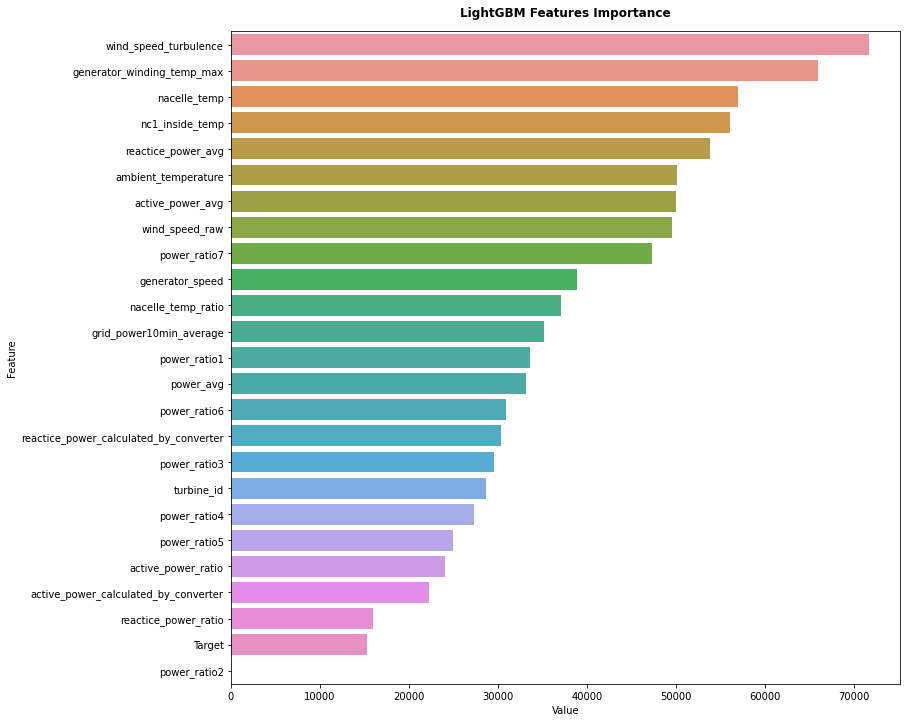

In [7]:
feature_imp = pd.DataFrame(sorted(zip(fet_imp[0:25],train.columns[0:25])), columns=['Value','Feature'])

plt.figure(figsize=(12, 12))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features Importance', fontweight='bold', pad=15);

## Create submission file

In [8]:
submission = pd.read_csv("../input/mh-renew-data/submission.csv")
submission['Target'] = lgb_model_preds
submission.to_csv("./lgb_submission.csv", index=False)
submission.head()

,Target
0,49.839281
1,41.128236
2,48.840070
3,46.686631
4,45.476544


In [9]:
## Good Day!!